In [1]:
import sys
sys.path.append('../../../')
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gmapy.data_management.object_utils import (
    load_objects, save_objects
)
from gmapy.mcmc_inference import compute_effective_sample_size
from gmapy.mappings.tf.compound_map_tf import CompoundMap
from gmapy.mappings.tf.restricted_map import RestrictedMap
from gmapy.gmap import run_gmap_simplified
from gmapy.legacy.legacy_gmap import run_gmap

2023-10-11 12:48:04.650981: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-11 12:48:04.652355: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-11 12:48:04.682984: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-11 12:48:04.684510: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 12:48:05.205264: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
#thisdir = '/home/gschnabel/Seafile/OmegaSpace/development/codeproj/gitrepos/gmapy/examples/tensorflow/example-005-std2017/output/'
thisdir = '/home/gschnabel/Seafile/OmegaSpace/development/codeproj/gitrepos/gmapy/examples/tensorflow/example-005-std2017/output/'
# gma_dbfile='../../../tests/testdata/data_and_sacs.json'
gma_dbfile='../../../legacy-tests/test_002/input/data.gma'
gma_dbtype='legacy'

# load the priortable
priortable, exptable, expcov, is_adj = load_objects(thisdir + '01_model_preparation_output.pkl', 'priortable', 'exptable', 'expcov', 'is_adj')
red_priortable = priortable.loc[is_adj].reset_index(drop=True)

tmp = red_priortable[['DESCR', 'REAC']].drop_duplicates()
tmp = tmp[~tmp.DESCR.isna()]
mtdic = {x: y for x, y in zip(tmp.DESCR, tmp.REAC)}

reacs = exptable.REAC.str.replace('MT:2', 'MT:1')
reacs = reacs.str.replace('MT:4', 'MT:3')
reacs = reacs.str.replace('MT:8', 'MT:5')
reacs = reacs.str.replace('MT:9', 'MT:7')
exptable['ABSREAC'] = reacs

In [3]:
# 1) load all the standard data from the standards 2017
#    to create a pseudo-experimental dataset
descr_list = []
outdt_list = []

tmp = pd.read_csv('std17-003_Li_006.txt', comment='#', index_col=None, sep=r'\s+')
descr = '6Li(n,a)'
descr_list.append(descr)
outdt_list.append(pd.DataFrame({'NODE': 'exp_1000', 'REAC': mtdic[descr], 'ENERGY': tmp.En.to_numpy(), 'DATA': tmp.CS.to_numpy(), 'UNC': tmp.DCS.to_numpy(), 'DESCR': descr}))

tmp = pd.read_csv('std17-005_B_010.txt', comment='#', index_col=None, sep=r'\s+')
descr = '10B(n,a1)'
descr_list.append(descr)
outdt_list.append(pd.DataFrame({'NODE': 'exp_1001','REAC': mtdic[descr], 'ENERGY': tmp.En.to_numpy(), 'DATA': tmp.CS.to_numpy(), 'UNC': tmp.DCS.to_numpy(), 'DESCR': descr}))
descr = '10B(n,a)'
outdt_list.append(pd.DataFrame({'NODE': 'exp_1002','REAC': 'MT:5-R1:3-R2:4', 'ENERGY': tmp.En.to_numpy(), 'DATA': tmp['CS.1'].to_numpy(), 'UNC': tmp['DCS.1'].to_numpy(), 'DESCR': descr}))

tmp = pd.read_csv('std17-079_Au_197.txt', comment='#', index_col=None, sep=r'\s+')
descr = 'Au(n,g)'
descr_list.append(descr)
outdt_list.append(pd.DataFrame({'NODE': 'exp_1003','REAC': mtdic[descr], 'ENERGY': tmp.En.to_numpy(), 'DATA': tmp['CS'].to_numpy(), 'UNC': tmp['DCS'].to_numpy(), 'DESCR': descr}))

tmp = pd.read_csv('std17-092_U_235.txt', comment='#', index_col=None, sep=r'\s+')
descr = 'U5(n,f)'
descr_list.append(descr)
outdt_list.append(pd.DataFrame({'NODE': 'exp_1004','REAC': mtdic[descr], 'ENERGY': tmp.En.to_numpy(), 'DATA': tmp['CS'].to_numpy(), 'UNC': tmp['DCS'].to_numpy(), 'DESCR': descr}))

tmp = pd.read_csv('std17-092_U_238.txt', comment='#', index_col=None, sep=r'\s+')
descr = 'U8(n,f)'
descr_list.append(descr)
outdt_list.append(pd.DataFrame({'NODE': 'exp_1005','REAC': mtdic[descr], 'ENERGY': tmp.En.to_numpy(), 'DATA': tmp['CS'].to_numpy(), 'UNC': tmp['DCS'].to_numpy(), 'DESCR': descr}))

tmp = pd.read_csv('rec17-094_Pu_239.txt', comment='#', index_col=None, sep=r'\s+')
descr = 'PU9(n,f)'
descr_list.append(descr)
outdt_list.append(pd.DataFrame({'NODE': 'exp_1006','REAC': mtdic[descr], 'ENERGY': tmp.En.to_numpy(), 'DATA': tmp['CS'].to_numpy(), 'UNC': tmp['DCS'].to_numpy(), 'DESCR': descr}))

tmp = pd.read_csv('rec17-092_U_238g.txt', comment='#', index_col=None, sep=r'\s+')
descr = 'U8(n,g)'
descr_list.append(descr)
outdt_list.append(pd.DataFrame({'NODE': 'exp_1007','REAC': mtdic[descr], 'ENERGY': tmp.En.to_numpy(), 'DATA': tmp['CS'].to_numpy(), 'UNC': tmp['DCS'].to_numpy(), 'DESCR': descr}))


In [4]:
# now for the thermal neutron constants
tmp = pd.read_csv('Standards2017_TNC.txt', comment='#', index_col=0, sep=r'\s+')

isos = tmp.columns
isos = isos[~isos.str.endswith('UNC')]
quants = tmp.index
exp_cnt = 1007
for iso in isos:
    for q in quants:
        exp_cnt += 1
        descr = f'{q}-{iso}'
        if descr == 'SF-U5':
            descr = 'U5(n,f)'
        elif descr == 'SF-PU9':
            descr = 'PU9(n,f)'
        print(descr)
        # create dataframe
        outdt_list.append(pd.DataFrame({
            'NODE': 'exp_' + str(exp_cnt), 'REAC': [mtdic[descr]],
            'ENERGY': 2.53e-8, 'DATA': tmp.loc[q, iso],
            'UNC': tmp.loc[q, iso + '-UNC'], 'DESCR': descr
        }))

SF-U3
SG-U3
SS-U3
U5(n,f)
SG-U5
SS-U5
PU9(n,f)
SG-PU9
SS-PU9
SF-PU1
SG-PU1
SS-PU1


In [5]:
outdt = pd.concat(outdt_list, ignore_index=True)
outdt = outdt.sort_values(['REAC', 'ENERGY'], ignore_index=True)

# create the mapping object
compmap = CompoundMap((priortable, outdt), reduce=True)
restrmap = RestrictedMap(len(is_adj), compmap.propagate, compmap.jacobian,
        fixed_params=priortable.loc[~is_adj, 'PRIOR'].to_numpy(copy=True),
        fixed_params_idcs=np.where(~is_adj)[0]
)
restrmap_prop = tf.function(restrmap.propagate)

In [6]:
# load a chain
chain, = load_objects(thisdir + '03_mcmc_sampling_output.pkl', 'chain')
optres, = load_objects(thisdir + '02_parameter_optimization_output.pkl', 'optres')

In [7]:
eval_mcmc_raw = np.mean(chain, axis=0)
eval_maxlike_raw = optres.position.numpy()

In [8]:
prop_chain = np.zeros((chain.shape[0], len(outdt)), dtype=np.float64)
for idx in range(chain.shape[0]):
    curchain = chain[idx, :len(red_priortable)]
    prop_chain[idx, :] = restrmap_prop(curchain)

# calculate the mean values
eval_mcmc = np.mean(prop_chain, axis=0)
eval_mcmc_unc = np.std(prop_chain, axis=0)
eval_maxlike = restrmap_prop(optres.position[:len(red_priortable)]).numpy()

In [9]:
# some plotting
outdt['PRED_ML'] = eval_maxlike
outdt['PRED_MCMC'] = eval_mcmc
outdt['PRED_MCMC_UNC'] = eval_mcmc_unc
outdt['PRED_ML_vs_STD2017'] = eval_maxlike / outdt['DATA'] - 1.
outdt['PRED_MCMC_vs_STD2017'] = eval_mcmc / outdt['DATA'] - 1.

In [10]:
gmap_res = run_gmap_simplified(
    dbfile=gma_dbfile, dbtype=gma_dbtype,
    num_iter=8
)
gmap_restable = gmap_res['table']
red_gmap_restable = gmap_restable[gmap_restable.NODE.str.match('xsid_|norm_')].reset_index(drop=True)

gmap_res = restrmap_prop(red_gmap_restable.POST.to_numpy())

/home/gschnabel/Seafile/OmegaSpace/development/codeproj/gitrepos/gmapy/examples/standard_studies/std2017/../../../gmapy/data_management/specialized_datablock_apis/legacy_datablock_uncertainty_api.py:122: RuntimeWarning: divide by zero encountered in double_scalars
  XYY = EPAF[1,L] - (E[KS]-E[KT])/(EPAF[2,L]*E[KS])


/home/gschnabel/Seafile/OmegaSpace/development/codeproj/gitrepos/gmapy/examples/standard_studies/std2017/../../../gmapy/data_management/specialized_datablock_apis/legacy_datablock_uncertainty_api.py:122: RuntimeWarning: divide by zero encountered in double_scalars
  XYY = EPAF[1,L] - (E[KS]-E[KT])/(EPAF[2,L]*E[KS])


/home/gschnabel/Seafile/OmegaSpace/development/codeproj/gitrepos/gmapy/examples/standard_studies/std2017/../../../gmapy/data_management/specialized_datablock_apis/legacy_datablock_uncertainty_api.py:122: RuntimeWarning: divide by zero encountered in double_scalars
  XYY = EPAF[1,L] - (E[KS]-E[KT])/(EPAF[2,L]*E[KS])


/home/gschnabel/Seafile/OmegaSpace/development/codeproj/gitrepos/gmapy/examples/standard_studies/std2017/../../../gmapy/data_management/specialized_datablock_apis/legacy_datablock_uncertainty_api.py:122: RuntimeWarning: divide by zero encountered in double_scalars
  XYY = EPAF[1,L] - (E[KS]-E[KT])/(EPAF[2,L]*E[KS])


/home/gschnabel/Seafile/OmegaSpace/development/codeproj/gitrepos/gmapy/examples/standard_studies/std2017/../../../gmapy/data_management/specialized_datablock_apis/legacy_datablock_uncertainty_api.py:122: RuntimeWarning: divide by zero encountered in double_scalars
  XYY = EPAF[1,L] - (E[KS]-E[KT])/(EPAF[2,L]*E[KS])


/home/gschnabel/Seafile/OmegaSpace/development/codeproj/gitrepos/gmapy/examples/standard_studies/std2017/../../../gmapy/data_management/specialized_datablock_apis/legacy_datablock_uncertainty_api.py:122: RuntimeWarning: divide by zero encountered in double_scalars
  XYY = EPAF[1,L] - (E[KS]-E[KT])/(EPAF[2,L]*E[KS])


/home/gschnabel/Seafile/OmegaSpace/development/codeproj/gitrepos/gmapy/examples/standard_studies/std2017/../../../gmapy/data_management/specialized_datablock_apis/legacy_datablock_uncertainty_api.py:122: RuntimeWarning: divide by zero encountered in double_scalars
  XYY = EPAF[1,L] - (E[KS]-E[KT])/(EPAF[2,L]*E[KS])


/home/gschnabel/Seafile/OmegaSpace/development/codeproj/gitrepos/gmapy/examples/standard_studies/std2017/../../../gmapy/data_management/specialized_datablock_apis/legacy_datablock_uncertainty_api.py:122: RuntimeWarning: divide by zero encountered in double_scalars
  XYY = EPAF[1,L] - (E[KS]-E[KT])/(EPAF[2,L]*E[KS])


/home/gschnabel/Seafile/OmegaSpace/development/codeproj/gitrepos/gmapy/examples/standard_studies/std2017/../../../gmapy/data_management/specialized_datablock_apis/legacy_datablock_uncertainty_api.py:122: RuntimeWarning: divide by zero encountered in double_scalars
  XYY = EPAF[1,L] - (E[KS]-E[KT])/(EPAF[2,L]*E[KS])


In [11]:
outdt['GMAP'] = gmap_res
outdt['GMAP_vs_STD2017'] = gmap_res / outdt['DATA']
outdt['GMAP/STD2017'] = gmap_res / outdt['DATA']

In [12]:
# look at the thermal constants
selcrit = (outdt.DESCR.str.match('S.-') | 
    ((outdt.ENERGY == 2.53e-8) & outdt.DESCR.isin(('U5(n,f)', 'U8(n,f)'))))
outdt['STD2017'] = outdt['DATA'].copy()
reldatacols = ['GMAP/STD2017', 'PRED_ML_vs_STD2017', 'PRED_MCMC_vs_STD2017']
plotdt = outdt.loc[selcrit, ['DESCR', 'STD2017'] + reldatacols].copy()
for col in reldatacols:
    plotdt[col] = plotdt[col] * 100
plotdt = plotdt.sort_values('PRED_MCMC_vs_STD2017')
plotdt
# reminder: mention SS-PU1 case, mention SG-U3 case

,DESCR,STD2017,GMAP/STD2017,PRED_ML_vs_STD2017,PRED_MCMC_vs_STD2017
158,SG-U3,44.90,93.334376,-6.810395,-6.368269
160,SG-U5,99.50,99.766849,-0.323846,-0.184764
165,SG-PU1,362.30,99.861208,-0.164428,-0.078855
357,"U5(n,f)",587.30,99.988154,-0.017243,-0.000805
356,"U5(n,f)",587.29,99.989856,-0.015540,0.000898
164,SF-PU1,1023.60,100.024348,0.008332,0.052286
159,SS-U5,14.09,100.004480,0.056800,0.126158
162,SG-PU9,269.80,100.231987,0.222102,0.244840
157,SF-U3,533.00,100.282030,0.286735,0.284576
156,SS-U3,12.20,100.249826,-0.030666,0.852167


In [13]:
outdt.columns

Index(['NODE', 'REAC', 'ENERGY', 'DATA', 'UNC', 'DESCR', 'PRED_ML',
       'PRED_MCMC', 'PRED_MCMC_UNC', 'PRED_ML_vs_STD2017',
       'PRED_MCMC_vs_STD2017', 'GMAP', 'GMAP_vs_STD2017', 'GMAP/STD2017',
       'STD2017'],
      dtype='object')

53173.08618187546


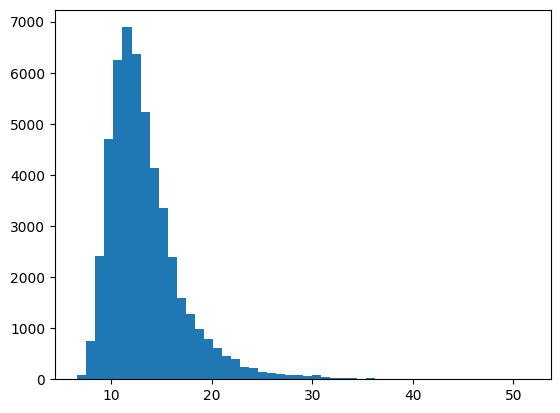

In [14]:
# explore the SS-PU1 case
# SS-PU1
selidx = outdt[(outdt.DESCR == 'SS-PU1')].index
curchain = prop_chain[:, selidx]
print(compute_effective_sample_size(curchain))
plt.hist(curchain, bins=50)
plt.show()

321130.5809464642


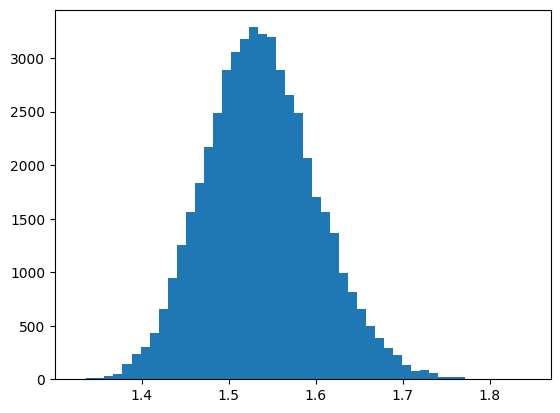

In [15]:
# SS-PU9
curchain = prop_chain[:, 479]
print(compute_effective_sample_size(curchain))
plt.hist(curchain, bins=50)
plt.show()

In [16]:
np.where(curchain > 40)[0]
testres = restrmap_prop(chain[10763, :])
outdt['TESTRES'] = testres

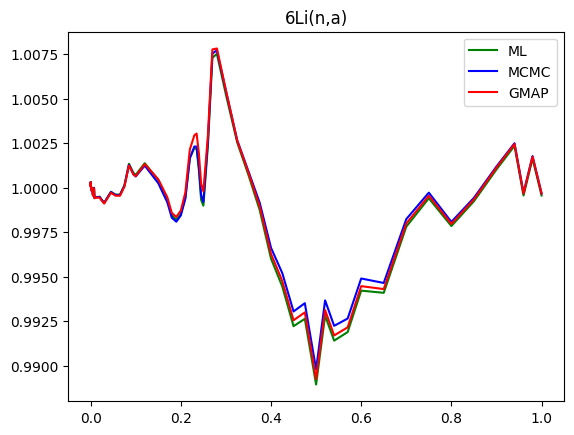

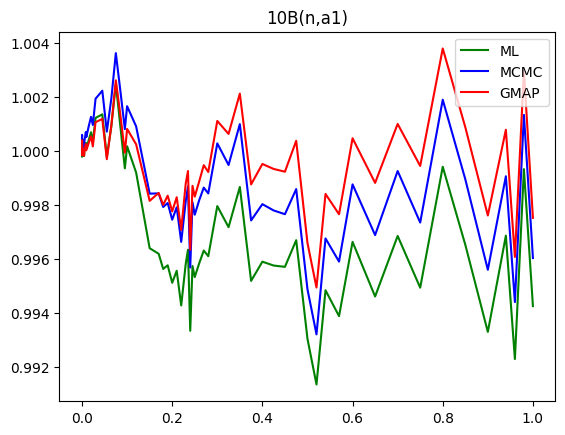

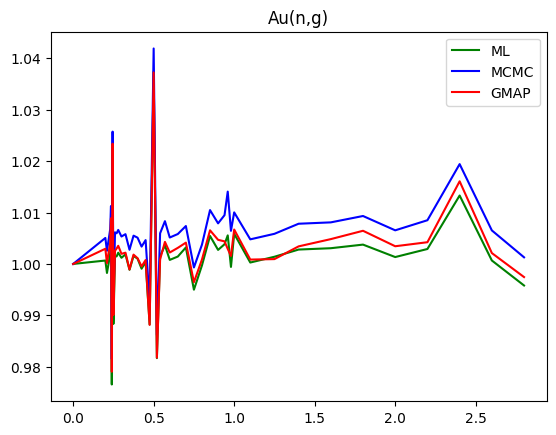

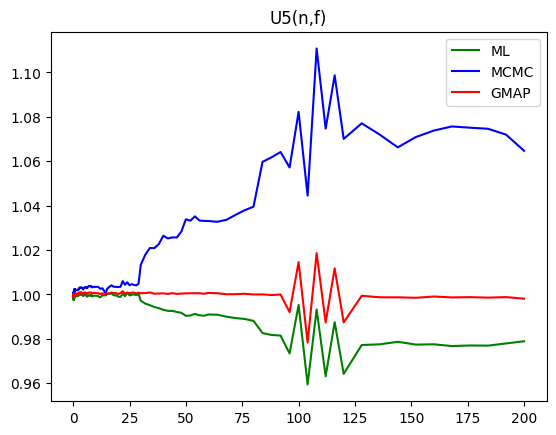

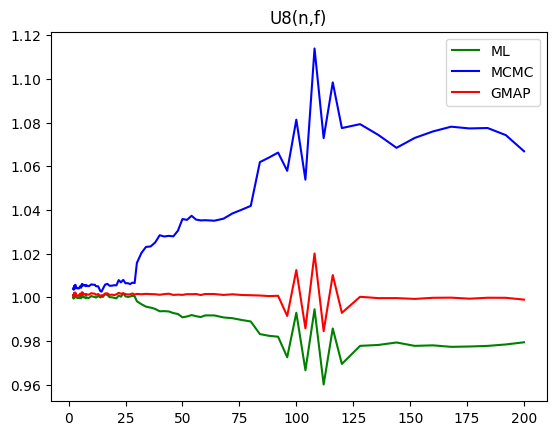

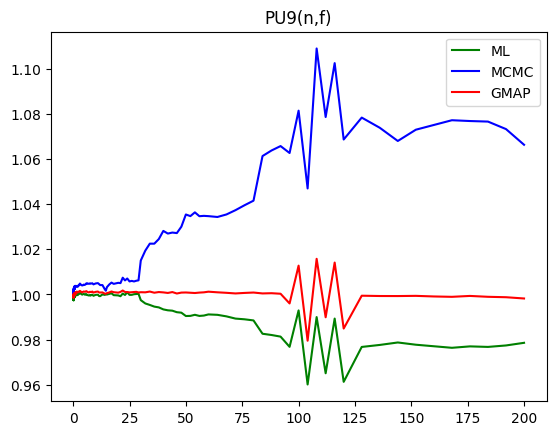

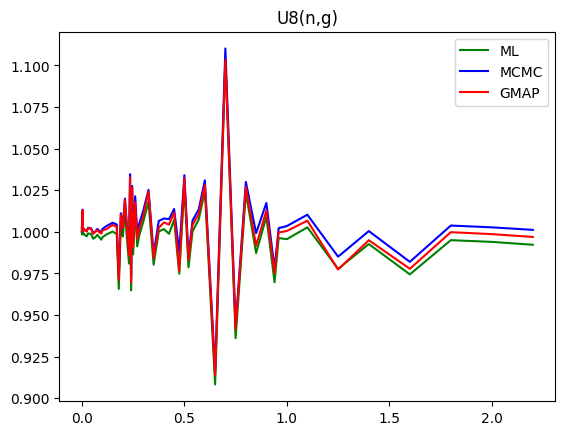

In [17]:
# show the energy-dependent quantities
for curdescr in descr_list:
    cdt = outdt[outdt.DESCR == curdescr]
    # plt.plot(cdt.ENERGY, cdt.PRED_ML)
    # plt.plot(cdt.ENERGY, cdt.PRED_MCMC)
    plt.plot(cdt.ENERGY, cdt.PRED_ML / cdt.DATA, color='green', label='ML')
    plt.plot(cdt.ENERGY, cdt.PRED_MCMC / cdt.DATA, color='blue', label='MCMC')
    plt.plot(cdt.ENERGY, cdt.GMAP / cdt.DATA, color='red', label='GMAP')
    # plt.plot(cdt.ENERGY, cdt.TESTRES / cdt.DATA, color='black', label='GMAP')
    # plt.axvline(x=30)
    plt.title(curdescr)
    plt.legend(loc='upper right')
    # plt.ylim(0.98, 1.01)
    plt.show()

In [18]:
outdt[outdt.DESCR=='U8(n,f)']

,NODE,REAC,ENERGY,DATA,UNC,DESCR,PRED_ML,PRED_MCMC,PRED_MCMC_UNC,PRED_ML_vs_STD2017,PRED_MCMC_vs_STD2017,GMAP,GMAP_vs_STD2017,GMAP/STD2017,STD2017,TESTRES
70,exp_1005,MT:1-R1:10,2.0,0.538,1.3,"U8(n,f)",0.537995,0.540154,0.003232,-0.000010,0.004005,0.538554,1.001030,1.001030,0.538,0.537920
71,exp_1005,MT:1-R1:10,2.2,0.550,1.3,"U8(n,f)",0.549659,0.551892,0.003206,-0.000620,0.003441,0.550258,1.000469,1.000469,0.550,0.549320
72,exp_1005,MT:1-R1:10,2.4,0.547,1.3,"U8(n,f)",0.547544,0.549817,0.003381,0.000994,0.005151,0.548067,1.001950,1.001950,0.547,0.553937
73,exp_1005,MT:1-R1:10,2.6,0.543,1.3,"U8(n,f)",0.542826,0.544992,0.003387,-0.000321,0.003669,0.543359,1.000661,1.000661,0.543,0.543416
74,exp_1005,MT:1-R1:10,2.8,0.539,1.4,"U8(n,f)",0.539655,0.542025,0.003609,0.001215,0.005612,0.540168,1.002168,1.002168,0.539,0.542852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,exp_1005,MT:1-R1:10,168.0,1.282,4.7,"U8(n,f)",1.252871,1.382101,0.069782,-0.022721,0.078082,1.281751,0.999806,0.999806,1.282,1.526800
152,exp_1005,MT:1-R1:10,176.0,1.325,4.6,"U8(n,f)",1.295103,1.427400,0.069251,-0.022564,0.077283,1.324111,0.999329,0.999329,1.325,1.556916
153,exp_1005,MT:1-R1:10,184.0,1.328,4.9,"U8(n,f)",1.298396,1.430887,0.073092,-0.022292,0.077475,1.327682,0.999761,0.999761,1.328,1.473518
154,exp_1005,MT:1-R1:10,192.0,1.311,4.5,"U8(n,f)",1.282649,1.408304,0.066408,-0.021626,0.074221,1.310650,0.999733,0.999733,1.311,1.546305


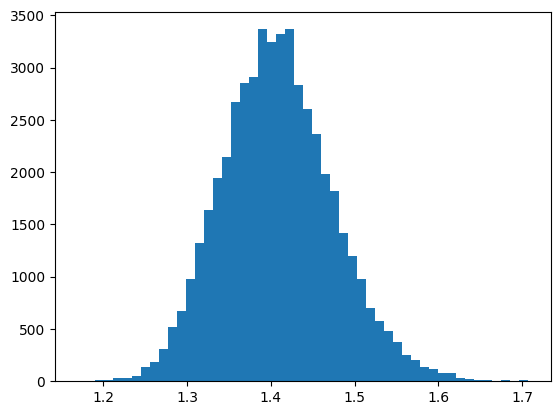

In [19]:
# U8(n,f) at 192 MeV
selidx = outdt[(outdt.DESCR == 'U8(n,f)') & (outdt.ENERGY==192.)].index
curchain = prop_chain[:, selidx]
compute_effective_sample_size(curchain)
plt.hist(curchain, bins=50)
plt.show()

In [20]:
# show what type of data we that refers to U5(n,f) 
exp_with_U5 = exptable[exptable.REAC.str.match('.*-R.:8')]
result = exp_with_U5.groupby('REAC').agg(MaxEn=('ENERGY', np.max), NumPts=('ENERGY', len))
result = result.sort_values('MaxEn')
result

,MaxEn,NumPts
REAC,,
MT:3-R1:14-R2:8,2.530000e-08,1
MT:3-R1:20-R2:8,2.530000e-08,1
MT:3-R1:30-R2:8,2.530000e-08,1
MT:4-R1:8-R2:4,2.400000e-02,21
MT:3-R1:8-R2:4,2.400000e-02,1
MT:3-R1:8-R2:6,6.500000e-02,2
MT:9-R1:8-R2:3-R3:4,1.500000e-01,280
MT:4-R1:8-R2:1,2.500000e-01,133
MT:6-R1:8,1.500000e+00,4


In [21]:
# prepare data renormalization factors
exptable['RENORM_DATA_ML'] = exptable['DATA'].copy()
exptable['RENORM_DATA_MCMC'] = exptable['DATA'].copy()
normdt = gmap_restable[gmap_restable.NODE.str.startswith('norm_')]
normdt = red_priortable[red_priortable.NODE.str.startswith('norm_')].copy()
# for MCMC result
rescale_vec_mcmc = np.mean(chain, axis=0)[normdt.index]
normdt['POST_MCMC'] = rescale_vec_mcmc
# for maxlike result
rescale_vec_ml = optres.position.numpy()[normdt.index]
normdt['POST_ML'] = rescale_vec_ml

In [22]:
# calculate renormalized data
for idx, row in normdt.iterrows():
    expid = row.NODE[5:]
    expname = 'exp_' + str(expid)
    if not (exptable.NODE == expname).any():
        raise ValueError()
    sel = exptable.NODE==expname
    exptable.loc[sel, 'RENORM_DATA_ML'] = exptable.loc[sel, 'DATA'] / row['POST_ML']
    exptable.loc[sel, 'RENORM_DATA_MCMC'] = exptable.loc[sel, 'DATA'] / row['POST_MCMC']

In [23]:
grouped = exptable.groupby('ABSREAC')
dflist = []
count = 2000
for idx, group in grouped:
    curnode = f'exp_{count}'
    curenergies = priortable.loc[priortable.REAC == idx, 'ENERGY'].to_numpy()
    curenergies = curenergies[(curenergies >= group.ENERGY.min()) & (curenergies <= group.ENERGY.max())]
    dflist.append(pd.DataFrame({'NODE': curnode, 'REAC': idx, 'ENERGY': curenergies}))
outdt2 = pd.concat(dflist)
compmap2 = CompoundMap((priortable, outdt2), reduce=True)

restrmap2 = RestrictedMap(len(is_adj), compmap2.propagate, compmap2.jacobian,
    fixed_params=priortable.loc[~is_adj, 'PRIOR'].to_numpy(copy=True),
    fixed_params_idcs=np.where(~is_adj)[0]
)
restrmap_prop2 = tf.function(restrmap2.propagate)
outdt2['PRED_ML'] = restrmap_prop2(eval_maxlike_raw)
outdt2['PRED_MCMC'] = restrmap_prop2(eval_mcmc_raw)

tmp = np.zeros((len(outdt2), chain.shape[0]), dtype=np.float64)
for i in range(chain.shape[0]):
    tmp[:, i] = restrmap_prop2(chain[i, :])
eval_mcmc_nonlinear = np.mean(tmp, axis=1)
outdt2['PRED_MCMC2'] = eval_mcmc_nonlinear

In [24]:
chain.shape

TensorShape([50000, 1116])

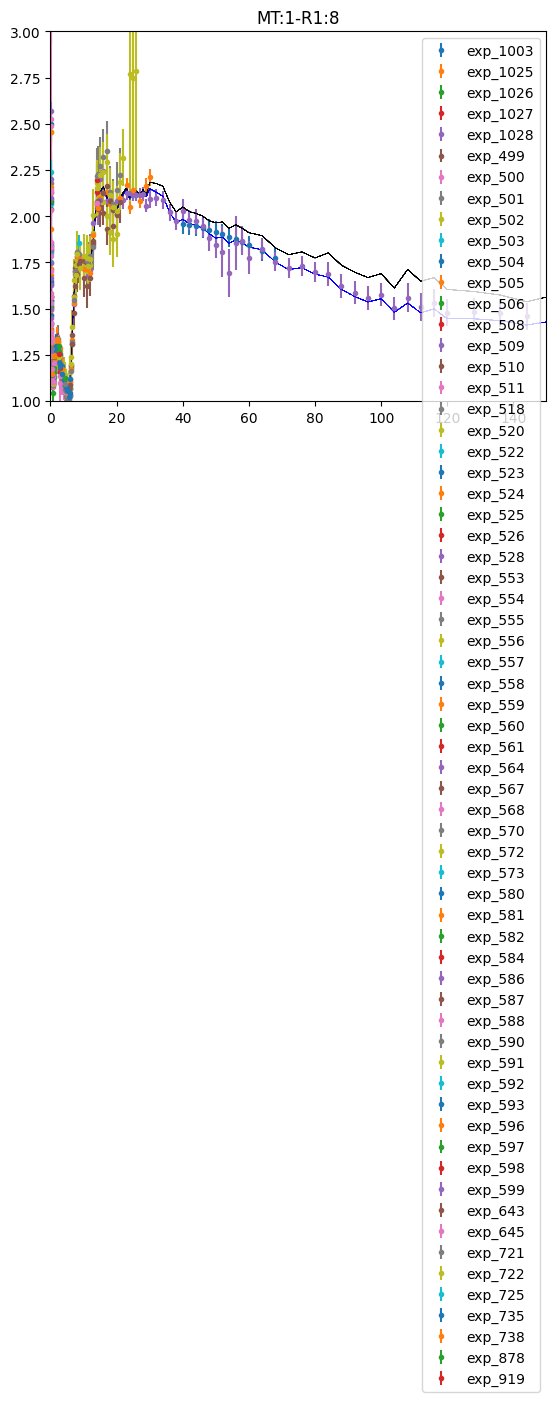

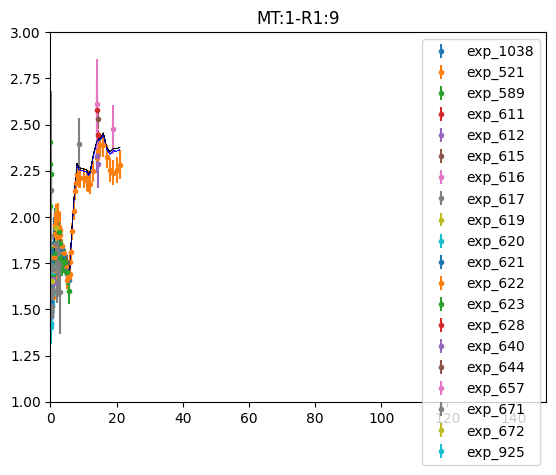

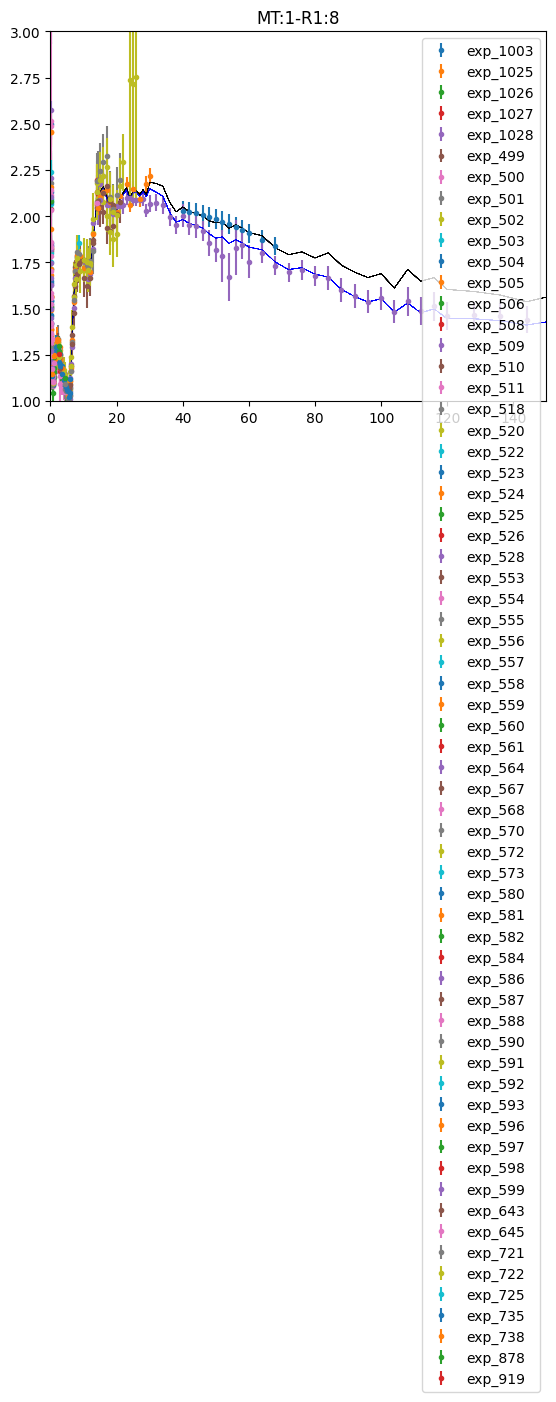

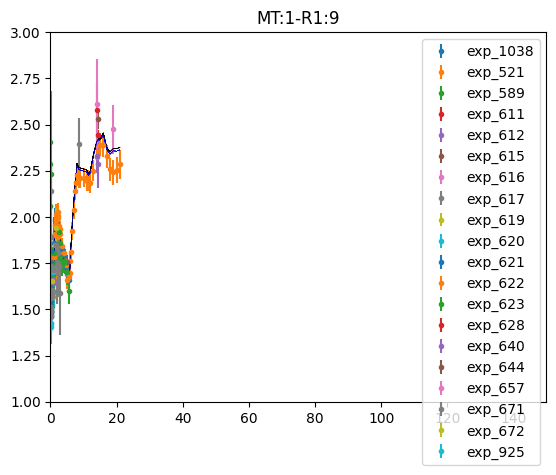

In [32]:
# select the column that the contains the posterior to be used for renormalization
for renorm_col in ('RENORM_DATA_ML', 'RENORM_DATA_MCMC'):
    #renorm_col = 'RENORM_DATA_ML'

    for curreac in ('MT:1-R1:8', 'MT:1-R1:9'):
        # curreac = 'MT:1-R1:8'
        #curreac = 'MT:2-R1:8'
        #curreac = 'MT:3-R1:9-R2:8'
        #curreac = 'MT:3-R1:10-R2:8'
        rtbl = exptable[(exptable.ABSREAC==curreac) & (exptable.ENERGY > 0)]
        grouped = rtbl.groupby('NODE')
        for gname, gdata in grouped:
            # plt.scatter(gdata['ENERGY'], gdata['RENORM_DATA'], s=5)
            plt.errorbar(gdata['ENERGY'], gdata[renorm_col], yerr=gdata['UNC'],
                    fmt='o', markersize=3, label=gdata['NODE'].iloc[0])
            tmp = outdt2[(outdt2.REAC == gdata['ABSREAC'].iloc[0]) & (outdt2.ENERGY > 0)]
            #plt.plot(tmp.ENERGY, tmp.PRED_MCMC2, color='black', lw=0.2)
            plt.plot(tmp.ENERGY, tmp.PRED_MCMC, color='black', lw=0.2)
            plt.plot(tmp.ENERGY, tmp.PRED_ML, color='blue', linestyle='--', lw=0.2)
            # plt.plot(tmp.ENERGY, tmp.PRED_MCMC / tmp.PRED_ML, color='black', linestyle='--', lw=0.2)
        
        plt.legend(loc='upper right')
        plt.xlim(0,150)
        #plt.xlim(0, 10)
        
        #plt.ylim(0.99, 1.01)
        plt.ylim(1, 3)
        plt.title(curreac)
        plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


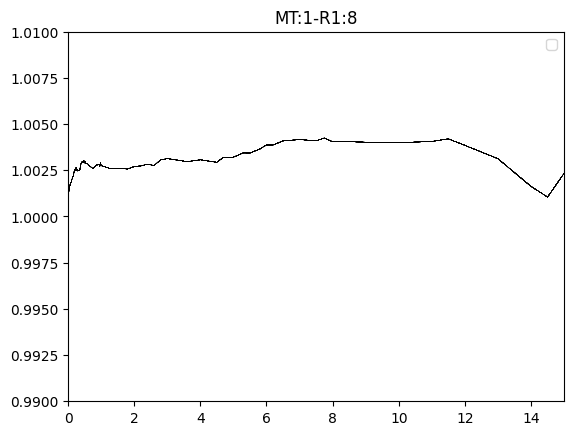

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


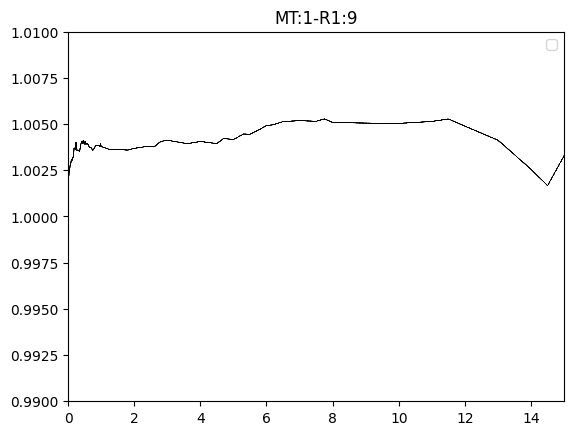

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


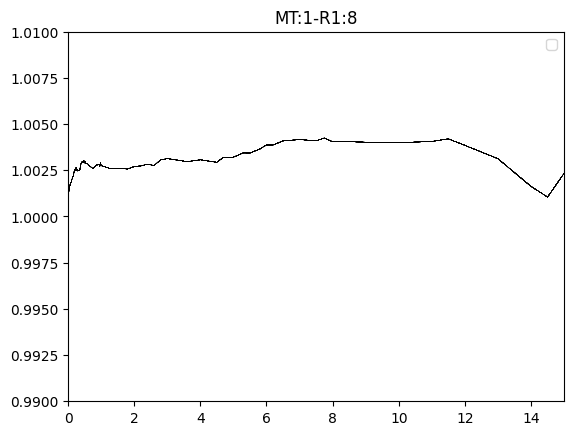

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


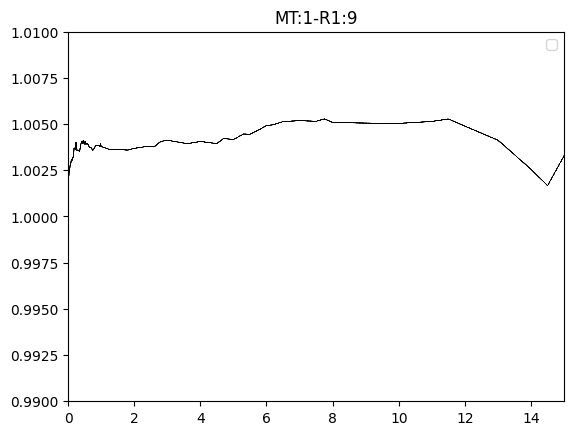

In [34]:
# select the column that the contains the posterior to be used for renormalization
for renorm_col in ('RENORM_DATA_ML', 'RENORM_DATA_MCMC'):
    #renorm_col = 'RENORM_DATA_ML'

    for curreac in ('MT:1-R1:8', 'MT:1-R1:9'):
        #curreac = 'MT:1-R1:8'
        #curreac = 'MT:2-R1:8'
        #curreac = 'MT:3-R1:9-R2:8'
        #curreac = 'MT:3-R1:10-R2:8'
        rtbl = exptable[(exptable.ABSREAC==curreac) & (exptable.ENERGY > 0)]
        grouped = rtbl.groupby('NODE')
        for gname, gdata in grouped:
            # plt.scatter(gdata['ENERGY'], gdata['RENORM_DATA'], s=5)
            # plt.errorbar(gdata['ENERGY'], gdata[renorm_col], yerr=gdata['UNC'],
            #        fmt='o', markersize=3, label=gdata['NODE'].iloc[0])
            tmp = outdt2[(outdt2.REAC == gdata['ABSREAC'].iloc[0]) & (outdt2.ENERGY > 0)]
            #plt.plot(tmp.ENERGY, tmp.PRED_MCMC2, color='black', lw=0.2)
            #plt.plot(tmp.ENERGY, tmp.PRED_MCMC, color='black', lw=0.2)
            # plt.plot(tmp.ENERGY, tmp.PRED_ML, color='blue', linestyle='dashed', lw=0.2)
            plt.plot(tmp.ENERGY, tmp.PRED_MCMC / tmp.PRED_ML, color='black', linestyle='--', lw=0.2)
        
        plt.legend(loc='upper right')
        # plt.xlim(0,150)
        plt.xlim(0, 15)
        
        plt.ylim(0.99, 1.01)
        # plt.ylim(1, 3)
        plt.title(curreac)
        plt.show()

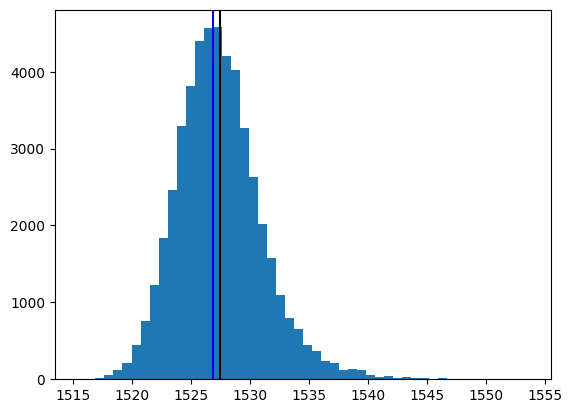

0.00038002609878546564

In [27]:
# marginal distribution along a non-axis direction
d = eval_mcmc_raw - eval_maxlike_raw
d = d / np.sqrt(np.sum(d**2))
project_chain = np.squeeze(chain.numpy() @ d.reshape(-1, 1))
# get mean and mode
tmp_mean = np.mean(project_chain)
hist, bin_edges = np.histogram(project_chain, bins=70)
tmp_mode = bin_edges[np.argmax(hist)]
# plot the histogram
hist = plt.hist(project_chain, bins=50)
plt.axvline(x=np.mean(project_chain), color='black')
plt.axvline(x=tmp_mode, color='blue')
plt.show()
# difference of expectation versus mean
(tmp_mean - tmp_mode) / tmp_mean 

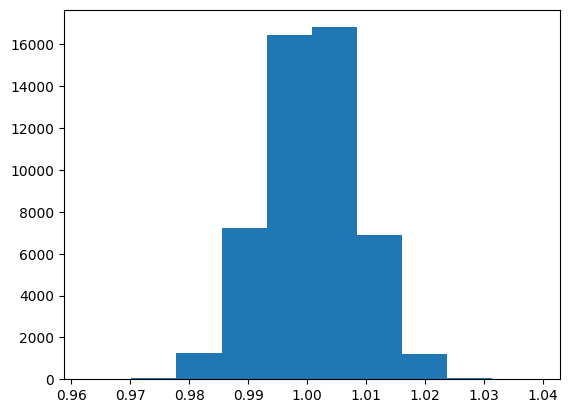

In [28]:
#import plotly.express as px
#fig = px.scatter(rtbl, x='ENERGY', y='DATA', color='NODE')
#fig.show()
idx1 = red_priortable[red_priortable.NODE=='norm_1028'].index
exptable[exptable.NODE=='exp_1028']
plt.hist(chain.numpy()[:, idx1])
plt.show()

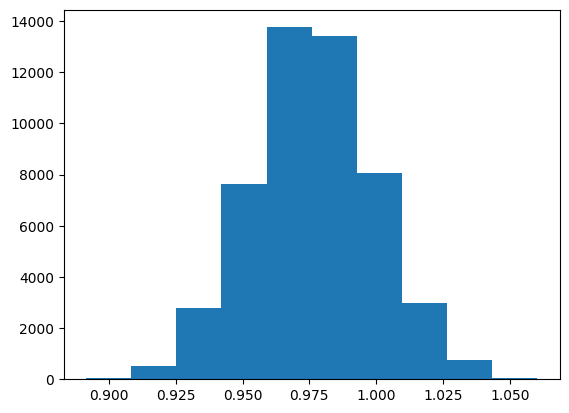

In [29]:
idx2 = red_priortable[red_priortable.NODE=='norm_1003'].index
plt.hist(chain.numpy()[:, idx2])
plt.show()

In [30]:
# show the difference of the normalization factor
idx1 = red_priortable[red_priortable.NODE=='norm_1028'].index
print(f'norm_1028 (maxlike): {np.squeeze(optres.position.numpy()[idx1])}')
print(f'norm_1028 (mcmc): {np.mean(chain.numpy()[:, idx1])}')

idx2 = red_priortable[red_priortable.NODE=='norm_1003'].index
print(f'norm_1003 (maxlike): {np.squeeze(optres.position.numpy()[idx2])}')
print(f'norm_1003 (mcmc): {np.mean(chain.numpy()[:, idx2])}')

norm_1028 (maxlike): 0.9879752343991702
norm_1028 (mcmc): 1.0006943111111488
norm_1003 (maxlike): 1.0112867628582178
norm_1003 (mcmc): 0.9764489828880336
